In [1]:
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, Reshape, Input, Embedding, LSTM, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.utils  import to_categorical
from datetime     import datetime
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

Using TensorFlow backend.


In [2]:
data_dir = 'numpy_arrays'

X  = 'train_picture_features_cropped.npy'
y  = 'train_picture_labels.npy'

train_features = np.load(os.path.join(data_dir, X))
train_labels   = np.load(os.path.join(data_dir, y))

X  = 'test_picture_features_cropped.npy'
y  = 'test_picture_labels.npy'

test_features = np.load(os.path.join(data_dir, X))
test_labels   = np.load(os.path.join(data_dir, y))

print("Train feature shape:", train_features.shape)
print("Train label shape:", train_labels.shape)
print("Test feature shape:", test_features.shape)
print("Test label shape:", test_labels.shape)

Train feature shape: (33402,)
Train label shape: (33402,)
Test feature shape: (13068,)
Test label shape: (13068,)


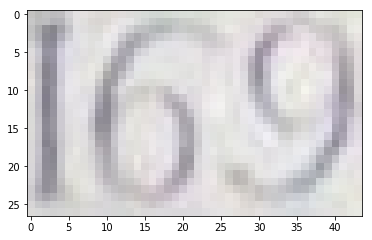

In [24]:
%matplotlib inline

def display(feature_array, label_array, num):
    #print("LABEL: {}".format(label_array[num] ))
    fig,ax  = plt.subplots(1)
    ax.imshow(feature_array[num])
    fig.savefig('sample.png')

display(train_features, train_labels, -1)

In [4]:
# Preprocessing features
from skimage.transform import resize

def pad_features(features):
    new_features = []
    for feature in features:
        #print(feature.shape)
        height, width, _ = feature.shape
        if height > width:
            pad = np.zeros((int(height), int((height - width) / 2), 3))
            tmp = np.concatenate((pad, feature, pad), axis=1)
                
        else:
            pad = np.zeros((int((width - height) / 2), int(width), 3))
            tmp = np.concatenate((pad, feature, pad), axis=0)

        new_features.append(tmp)
    return np.array(new_features)

#################################

def resize_32x32(features):
    return np.array([resize(f, (32, 32, 3), mode='constant') for f in features])

def resize_32x32_grey(features):
    return np.array([resize(f, (32, 32, 1), mode='constant') for f in features])

def resize_64x64(features):
    return np.array([resize(f, (64, 64, 3), mode='constant') for f in features])


In [5]:
def preprocess_features(features):
    features = pad_features(features)
    features = resize_32x32(features)

    return features

In [6]:
# Preprocessing targets

def pad_labels(labels):

    max_len = 6
    
    for arr in labels:
        max_len = max(len(arr), max_len)
    
    return np.array([((max_len - len(arr)) * [10.0]) + arr for arr in labels])

def one_hot_encoding(labels):
    return np.array([ to_categorical(label, num_classes=11) for label in labels])

def remove_10s(labels):
    for label in labels:
        for i, digit in enumerate(label):
            if digit > 9:
                label[i] = 0.
                
    return labels

In [7]:
def preprocess_labels(labels):
    labels = remove_10s(labels)
    labels = pad_labels(labels)
    labels = one_hot_encoding(labels)
    labels = [labels[:, i] for i in range(6)]
    
    return labels

In [8]:
processed_train_features = preprocess_features(train_features)  
processed_train_labels   = preprocess_labels(train_labels)

processed_test_features  = preprocess_features(test_features)  
processed_test_labels    = preprocess_labels(test_labels)

print("Train feature shape:", processed_train_features.shape)
print("Train label shape: {} * {}".format(len(processed_train_labels), processed_train_labels[0].shape))
print("Test feature shape:", processed_test_features.shape)
print("Test label shape: {} * {}".format(len(processed_test_labels), processed_test_labels[0].shape))

Train feature shape: (33402, 32, 32, 3)
Train label shape: 6 * (33402, 11)
Test feature shape: (13068, 32, 32, 3)
Test label shape: 6 * (13068, 11)


array([10, 10, 10,  1,  6,  9])

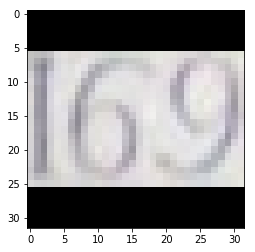

In [10]:
def decode_label(labels, num):
    return np.array([np.argmax(labels[digit_num][num]) for digit_num in range(len(labels))] )
    
display(processed_train_features, train_labels, -1)
decode_label(processed_train_labels, -1)

In [11]:
inputs_ = Input(shape=(32,32,3))
x = inputs_

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

###########################################
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)

digit1 = Dense(11, activation='softmax', name='digit1')(x)
digit2 = Dense(11, activation='softmax', name='digit2')(x)
digit3 = Dense(11, activation='softmax', name='digit3')(x)
digit4 = Dense(11, activation='softmax', name='digit4')(x)
digit5 = Dense(11, activation='softmax', name='digit5')(x)
digit6 = Dense(11, activation='softmax', name='digit6')(x)

model = Model(input=inputs_, outputs=[digit1, digit2, digit3, digit4, digit5, digit6])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 32, 64)    1792                                         
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 16, 16, 64)    0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 16, 16, 64)    256                                          
___________________________________________________________________________________________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


In [12]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint

epochs     = 25
time_now   = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join('models', 'multidigits' + str(epochs) + 'epochs_' + time_now +'.hdf5')

print("MODEL FILE: {}".format(model_path))

checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, save_best_only=True, monitor='acc',)

model.fit(processed_train_features, 
          processed_train_labels,
          epochs=epochs, 
          batch_size=32, 
          callbacks=[checkpointer], 
          validation_data=(processed_test_features, processed_test_labels),
          verbose=1)


MODEL FILE: models/multidigits25epochs_20190716_191907.hdf5
Train on 33402 samples, validate on 13068 samples
Epoch 1/25
33402/33402 [==============================] - 266s - loss: 4.8208 - digit1_loss: 0.0046 - digit2_loss: 0.0071 - digit3_loss: 0.1473 - digit4_loss: 0.7958 - digit5_loss: 1.7917 - digit6_loss: 2.0742 - digit1_acc: 0.9990 - digit2_acc: 0.9988 - digit3_acc: 0.9578 - digit4_acc: 0.7584 - digit5_acc: 0.3792 - digit6_acc: 0.2470 - val_loss: 3.3771 - val_digit1_loss: 1.5959e-06 - val_digit2_loss: 0.0020 - val_digit3_loss: 0.0519 - val_digit4_loss: 0.3746 - val_digit5_loss: 1.2876 - val_digit6_loss: 1.6609 - val_digit1_acc: 1.0000 - val_digit2_acc: 0.9998 - val_digit3_acc: 0.9852 - val_digit4_acc: 0.8947 - val_digit5_acc: 0.5775 - val_digit6_acc: 0.4185

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:388: RuntimeWarning: Can save best model only with acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)



Epoch 2/25
33402/33402 [==============================] - 267s - loss: 3.3975 - digit1_loss: 4.8336e-04 - digit2_loss: 0.0041 - digit3_loss: 0.1187 - digit4_loss: 0.5895 - digit5_loss: 1.2695 - digit6_loss: 1.4152 - digit1_acc: 1.0000 - digit2_acc: 0.9997 - digit3_acc: 0.9672 - digit4_acc: 0.8172 - digit5_acc: 0.5739 - digit6_acc: 0.5074 - val_loss: 2.3987 - val_digit1_loss: 1.2618e-07 - val_digit2_loss: 0.0024 - val_digit3_loss: 0.0413 - val_digit4_loss: 0.3095 - val_digit5_loss: 0.9376 - val_digit6_loss: 1.1079 - val_digit1_acc: 1.0000 - val_digit2_acc: 0.9998 - val_digit3_acc: 0.9871 - val_digit4_acc: 0.9061 - val_digit5_acc: 0.6903 - val_digit6_acc: 0.6282
Epoch 3/25
33402/33402 [==============================] - 266s - loss: 2.7983 - digit1_loss: 4.8271e-04 - digit2_loss: 0.0048 - digit3_loss: 0.1073 - digit4_loss: 0.5292 - digit5_loss: 1.0592 - digit6_loss: 1.0973 - digit1_acc: 1.0000 - digit2_acc: 0.9997 - digit3_acc: 0.9713 - digit4_acc: 0.8333 - digit5_acc: 0.6439 - digit6_ac

33402/33402 [==============================] - 267s - loss: 1.8717 - digit1_loss: 4.8267e-04 - digit2_loss: 0.0048 - digit3_loss: 0.0926 - digit4_loss: 0.4042 - digit5_loss: 0.6833 - digit6_loss: 0.6863 - digit1_acc: 1.0000 - digit2_acc: 0.9997 - digit3_acc: 0.9780 - digit4_acc: 0.8760 - digit5_acc: 0.7805 - digit6_acc: 0.7727 - val_loss: 2.3463 - val_digit1_loss: 1.1921e-07 - val_digit2_loss: 0.0025 - val_digit3_loss: 0.1253 - val_digit4_loss: 0.4925 - val_digit5_loss: 0.7814 - val_digit6_loss: 0.9447 - val_digit1_acc: 1.0000 - val_digit2_acc: 0.9998 - val_digit3_acc: 0.9536 - val_digit4_acc: 0.8440 - val_digit5_acc: 0.7707 - val_digit6_acc: 0.6917
Epoch 15/25
33402/33402 [==============================] - 267s - loss: 1.8596 - digit1_loss: 4.8267e-04 - digit2_loss: 0.0048 - digit3_loss: 0.0930 - digit4_loss: 0.3986 - digit5_loss: 0.6847 - digit6_loss: 0.6779 - digit1_acc: 1.0000 - digit2_acc: 0.9997 - digit3_acc: 0.9787 - digit4_acc: 0.8775 - digit5_acc: 0.7807 - digit6_acc: 0.7791 -

In [13]:
tmp = model.evaluate(processed_test_features, processed_test_labels, verbose=0)
loss, d1_loss, d2_loss, d3_loss, d4_loss, d5_loss, d6_loss, d1_acc, d2_acc, d3_acc, d4_acc, d5_acc, d6_acc = tmp

mean_loss = np.mean([d1_loss, d2_loss, d3_loss, d4_loss, d5_loss, d6_loss])
mean_acc  = np.mean([d1_acc, d2_acc, d3_acc, d4_acc, d5_acc, d6_acc])

print("LOSS: {}, ACCURACY: {}".format(mean_loss, mean_acc))

LOSS: 0.25594659207106224, ACCURACY: 0.9219084787236199


In [21]:
def predict(array):
    y_pred = model.predict(array)
    y_pred = np.array(y_pred)

    entries = [y_pred[:, i, :] for i in range(y_pred.shape[1])]

    all_digits = []
    for entry in entries:
        
        entry_digits = []
        for digit in entry:
            entry_digits.append(np.argmax(digit))

        all_digits.append(entry_digits)
   
    return np.array(all_digits).astype('float64')


samples     = 20
predictions = predict(processed_test_features[:samples])
for i, prediction in enumerate(predictions):
    p     = "".join([str(int(digit)) for digit in prediction if digit != 10.])
    label = "".join([str(int(digit)) for digit in test_labels[i]])
    print("Label: {}\tPrediction: {}".format(label, p))

Label: 5	Prediction: 5
Label: 210	Prediction: 210
Label: 6	Prediction: 6
Label: 1	Prediction: 1
Label: 9	Prediction: 9
Label: 1	Prediction: 1
Label: 183	Prediction: 183
Label: 65	Prediction: 35
Label: 144	Prediction: 184
Label: 16	Prediction: 16
Label: 34	Prediction: 34
Label: 20	Prediction: 20
Label: 13	Prediction: 19
Label: 25	Prediction: 25
Label: 4	Prediction: 14
Label: 14	Prediction: 14
Label: 28	Prediction: 20
Label: 38	Prediction: 38
Label: 60	Prediction: 60
Label: 151	Prediction: 151


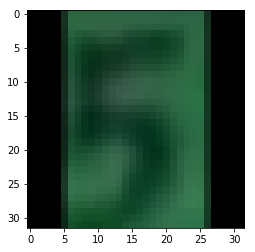

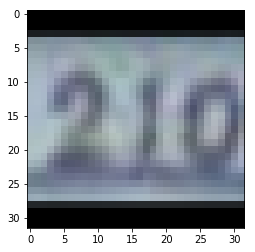

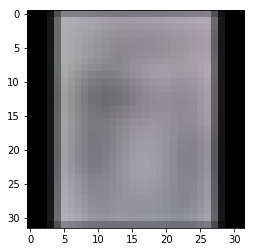

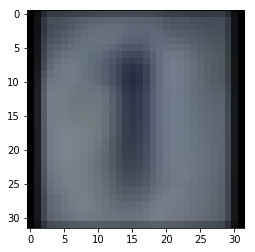

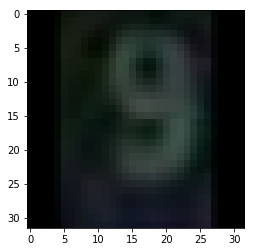

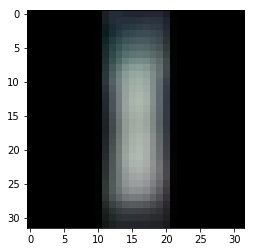

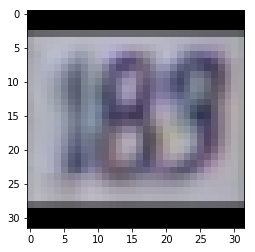

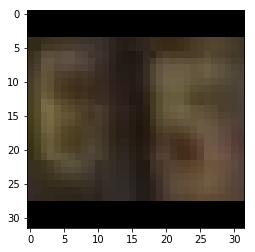

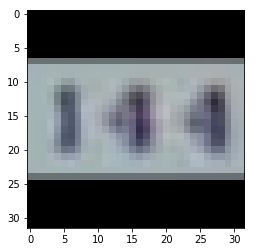

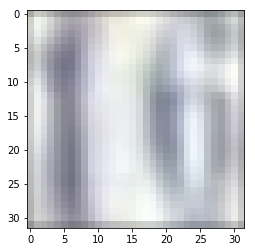

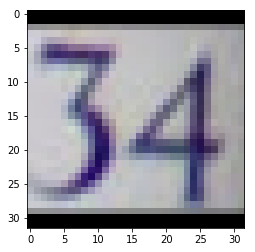

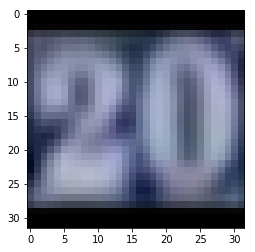

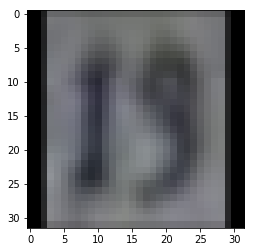

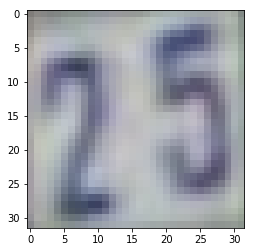

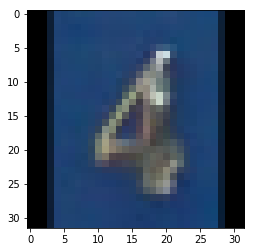

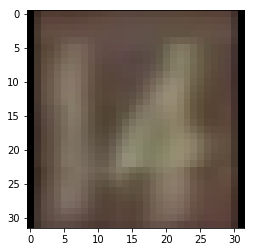

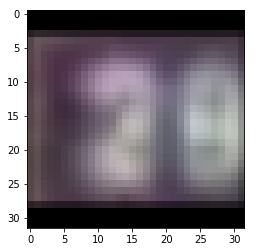

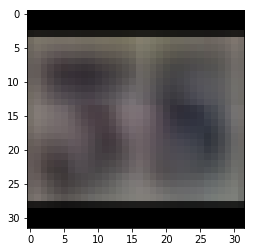

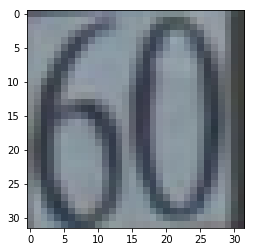

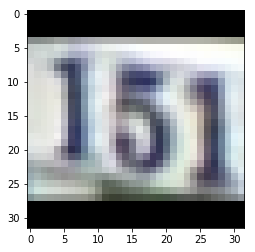

In [25]:
for i in range(samples):
    display(processed_test_features, processed_test_labels, i)

In [35]:
model.history.history.keys()


dict_keys(['digit1_loss', 'digit6_acc', 'val_digit3_acc', 'val_digit4_loss', 'val_digit5_loss', 'val_digit6_acc', 'val_digit2_acc', 'digit3_acc', 'val_digit1_acc', 'val_loss', 'val_digit6_loss', 'digit3_loss', 'digit4_loss', 'val_digit2_loss', 'loss', 'digit5_acc', 'digit4_acc', 'digit2_acc', 'val_digit3_loss', 'val_digit4_acc', 'digit5_loss', 'val_digit5_acc', 'digit6_loss', 'digit2_loss', 'digit1_acc', 'val_digit1_loss'])

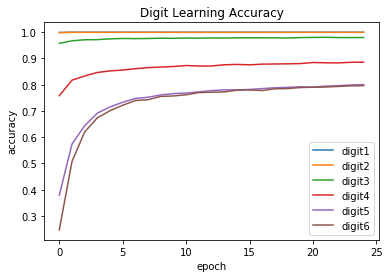

In [42]:
accuracies = ['digit1_acc', 'digit2_acc', 'digit3_acc', 'digit4_acc', 'digit5_acc', 'digit6_acc']
for acc in accuracies:
    plt.plot(model.history.history[acc], label=acc.split('_')[0])

plt.title('Digit Learning Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()